# NLP Assignment: Character Signatures (Collocates & PMI)

## Goal
Analyze the text to find "Character Signatures":
1.  **Frequency:** Words that appear most often near the character.
2.  **PMI (Pointwise Mutual Information):** Words that are statistically strongly associated with the character (unique to them).

## Output
* **Visuals:** Side-by-side Bar Charts (Frequency vs. PMI) for main characters.
* **Data:** CSV files with full lists.

In [6]:
# INSTALL MISSING LIBRARIES
# Run this cell once to fix the 'ModuleNotFoundError: No module named wordcloud' error
%pip install wordcloud pandas matplotlib nltk

In [7]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

# --- 1. CONFIGURATION ---

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Path Setup (Going up one level from 'notebooks' to find 'data')
DATA_DIR = '../data'
RESULTS_DIR = '../results'

if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# Analysis Settings
WINDOW_SIZE = 5         # +/- 5 words
PMI_FREQ_THRESHOLD = 5  # Word must appear 5+ times to be considered for PMI
TOP_N = 10              # Top 10 words for the graph (as per assignment)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Processing Functions

In [8]:
def load_and_clean(filename):
    filepath = os.path.join(DATA_DIR, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"ERROR: Could not find {filepath}")
        return [], []

    # Initialize NLP tools
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize
    sentences = sent_tokenize(text)
    processed_sentences = []
    full_tokens = []
    
    print(f"Processing {len(sentences)} sentences...")
    
    for sent in sentences:
        words = word_tokenize(sent)
        clean_words = []
        for w in words:
            if w.isalnum():
                w_lower = w.lower()
                if w_lower not in stop_words:
                    lemma = lemmatizer.lemmatize(w_lower)
                    clean_words.append(lemma)
                    full_tokens.append(lemma)
        if clean_words:
            processed_sentences.append(clean_words)
            
    return full_tokens, processed_sentences

def get_collocates(target, sentences, window=5):
    target = target.lower()
    collocates = []
    for sent in sentences:
        for i, word in enumerate(sent):
            if word == target:
                start = max(0, i - window)
                end = min(len(sent), i + window + 1)
                # Add context (excluding the target word itself)
                collocates.extend(sent[start:i] + sent[i+1:end])
    return collocates

def calculate_pmi(collocates, full_tokens, top_n=10):
    collocate_counts = Counter(collocates)
    corpus_counts = Counter(full_tokens)
    total_collocates = len(collocates)
    total_corpus = len(full_tokens)
    
    pmi_scores = {}
    for word, count in collocate_counts.items():
        if count < PMI_FREQ_THRESHOLD: continue
        
        p_w_given_c = count / total_collocates
        p_w = corpus_counts[word] / total_corpus
        
        if p_w > 0:
            pmi_scores[word] = math.log(p_w_given_c / p_w)
            
    # Get Top Frequency and Top PMI
    top_freq = collocate_counts.most_common(top_n)
    top_pmi = sorted(pmi_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    return top_freq, top_pmi

## 3. Visualization Function
Creates the exact side-by-side graph requested: Top Frequency on the left, Top PMI on the right.

In [9]:
def create_assignment_graph(char_name, top_freq, top_pmi, book_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # 1. Frequency Plot
    words_f, counts_f = zip(*top_freq)
    axes[0].barh(words_f[::-1], counts_f[::-1], color='#4c72b0')
    axes[0].set_title(f"Top {TOP_N} Collocates (Frequency)")
    axes[0].set_xlabel("Count")

    # 2. PMI Plot
    words_p, scores_p = zip(*top_pmi)
    axes[1].barh(words_p[::-1], scores_p[::-1], color='#55a868')
    axes[1].set_title(f"Top {TOP_N} Collocates (PMI Score)")
    axes[1].set_xlabel("PMI Value")

    plt.suptitle(f"Character Signature: {char_name} ({book_name})", fontsize=16)
    plt.tight_layout()
    
    # Save
    filename = f"{RESULTS_DIR}/{char_name}_signature.png"
    plt.savefig(filename)
    print(f"Graph saved to: {filename}")
    plt.show()

## 4. Main Execution
We will analyze **Anna** and **Levin** from *Anna Karenina* to produce clean, representative results.

Processing 16927 sentences...

Analyzing Anna...
Graph saved to: ../results/Anna_signature.png


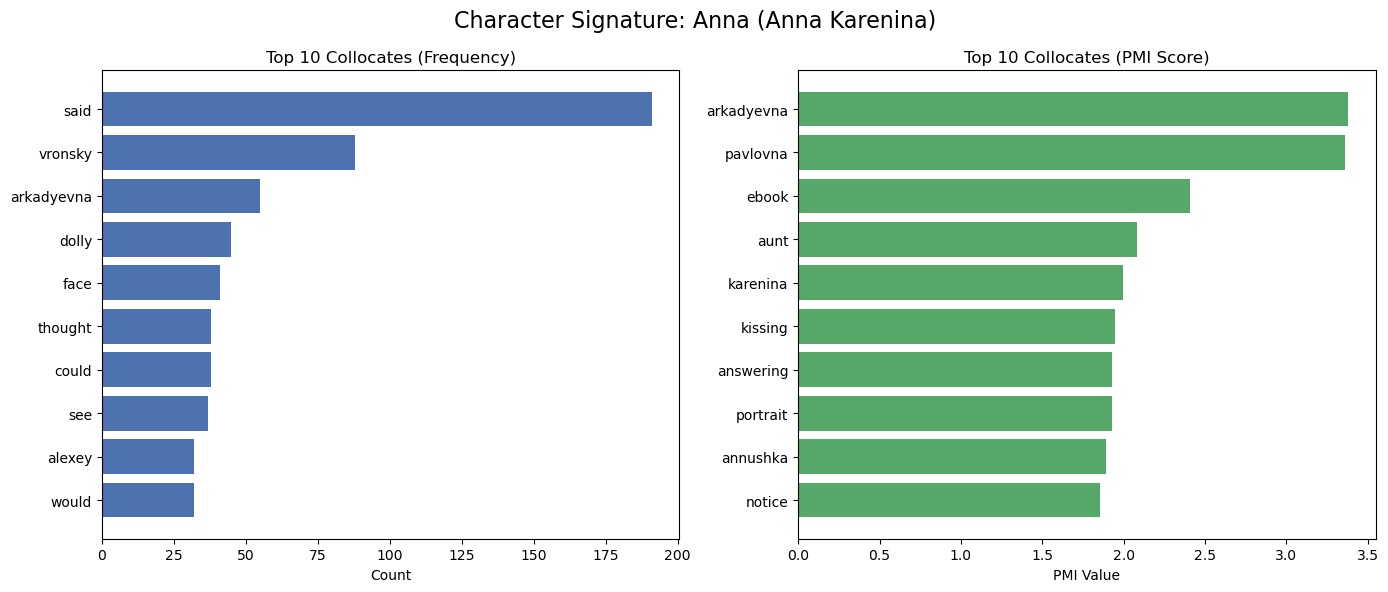


Analyzing Levin...
Graph saved to: ../results/Levin_signature.png


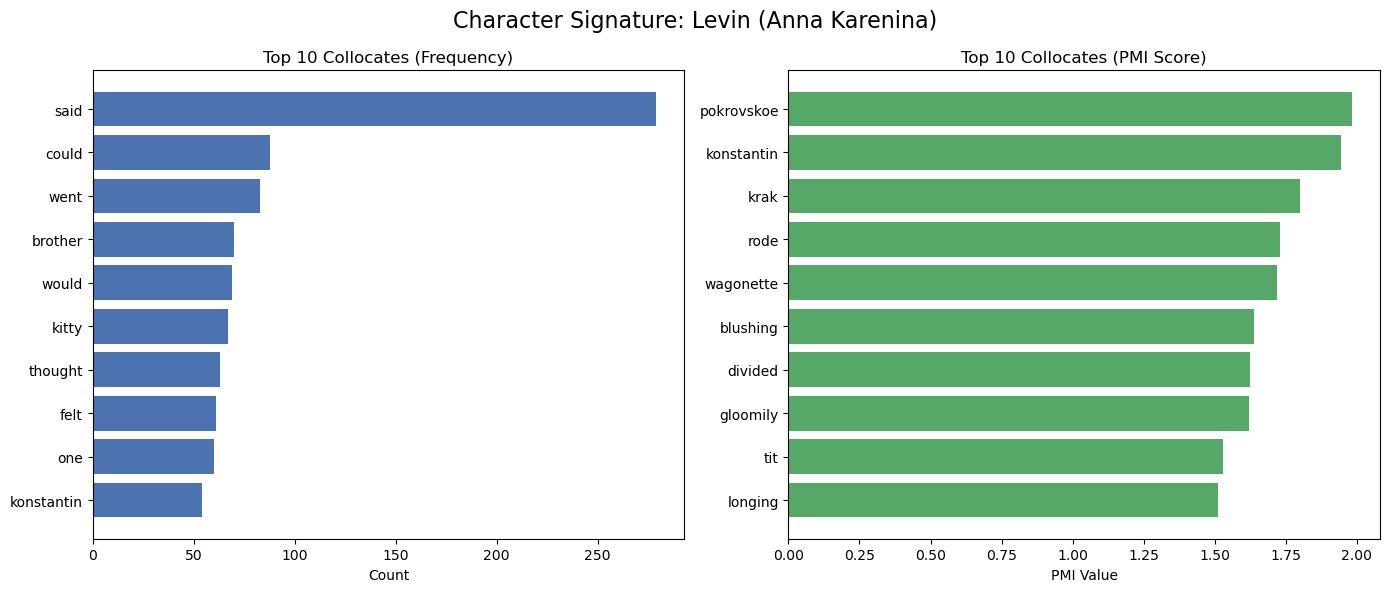


Done! Checked results folder for PNGs and CSVs.


In [10]:
# Define what to analyze
BOOK_FILE = "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt"
CHARACTERS = ["Anna", "Levin"] # The two main contrasts

# 1. Load Data
full_tokens, sentences = load_and_clean(BOOK_FILE)

if full_tokens:
    for char in CHARACTERS:
        print(f"\nAnalyzing {char}...")
        
        # 2. Get Context & Stats
        collocates = get_collocates(char, sentences, WINDOW_SIZE)
        if not collocates:
            print(f"Character {char} not found!")
            continue
            
        top_freq, top_pmi = calculate_pmi(collocates, full_tokens, TOP_N)
        
        # 3. Generate Graph
        create_assignment_graph(char, top_freq, top_pmi, "Anna Karenina")
        
        # 4. Save CSV (Requirement)
        df_f = pd.DataFrame(top_freq, columns=['Word', 'Frequency'])
        df_p = pd.DataFrame(top_pmi, columns=['Word', 'PMI_Score'])
        # Save separately or merged, here we save the top lists
        df_f.to_csv(f"{RESULTS_DIR}/{char}_freq.csv", index=False)
        df_p.to_csv(f"{RESULTS_DIR}/{char}_pmi.csv", index=False)

print("\nDone! Checked results folder for PNGs and CSVs.")